In [1]:
import numpy as np
import pandas as pd
import datetime
import time
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import h2o
from h2o.targetencoder import TargetEncoder

import os
#os.environ["CUDA_VISIBLE_DEVICES"]="7"
os.environ["CUDA_VISIBLE_DEVICES"]=""

/opt/rh/rh-python36/root/usr/lib64/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/opt/rh/rh-python36/root/usr/lib64/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
notebook_tic = time.time()

In [3]:
h2o.init(ip="127.0.0.1", max_mem_size_GB = 200, nthreads = 5)

Checking whether there is an H2O instance running at http://127.0.0.1:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "1.8.0_212"; OpenJDK Runtime Environment (build 1.8.0_212-b04); OpenJDK 64-Bit Server VM (build 25.212-b04, mixed mode)
  Starting server from /workspaces/sefik/.local/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpixk49g3f
  JVM stdout: /tmp/tmpixk49g3f/h2o_sefik_started_from_python.out
  JVM stderr: /tmp/tmpixk49g3f/h2o_sefik_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O cluster uptime:,01 secs
H2O cluster timezone:,Europe/Istanbul
H2O data parsing timezone:,UTC
H2O cluster version:,3.26.0.3
H2O cluster version age:,2 months and 13 days
H2O cluster name:,H2O_from_python_sefik_kxcdde
H2O cluster total nodes:,1
H2O cluster free memory:,177.8 Gb
H2O cluster total cores:,72
H2O cluster allowed cores:,5
H2O cluster status:,"accepting new members, healthy"


In [4]:
tic = time.time()

train = pd.read_csv('train.csv')
print("train loaded")
metadata = pd.read_csv('building_metadata.csv')
print("metadata loaded")
train = train.merge(metadata, on="building_id", how="left")
print("train and metadata merged")

weather = pd.read_csv('weather_train.csv')
print("weather loaded")
train = train.merge(weather, on=["site_id", "timestamp"], how="left")
print("train and weather merged")

toc = time.time()

print(toc - tic," seconds")

train loaded
metadata loaded
train and metadata merged
weather loaded
train and weather merged
17.77210545539856  seconds


In [5]:
#very large target causes trouble for rmsle
#restore this with np.expm1 in prediction
train['meter_reading'] = np.log1p(train['meter_reading']).astype(np.float32)

In [6]:
tic = time.time()

hf_train = h2o.H2OFrame(train) # 4 minutes avg time

toc = time.time()
print(toc-tic," seconds")

Parse progress: |█████████████████████████████████████████████████████████| 100%
251.08276844024658  seconds


In [7]:
target_label = 'meter_reading'

In [8]:
#we no longer need to store pandas data frame
del train

In [9]:
hf_train.head()

building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,2016-01-01 00:00:00,0,0,Education,7432,2008,nan,25,6,20,nan,1019.7,0,0
1,0,2016-01-01 00:00:00,0,0,Education,2720,2004,nan,25,6,20,nan,1019.7,0,0
2,0,2016-01-01 00:00:00,0,0,Education,5376,1991,nan,25,6,20,nan,1019.7,0,0
3,0,2016-01-01 00:00:00,0,0,Education,23685,2002,nan,25,6,20,nan,1019.7,0,0
4,0,2016-01-01 00:00:00,0,0,Education,116607,1975,nan,25,6,20,nan,1019.7,0,0
5,0,2016-01-01 00:00:00,0,0,Education,8000,2000,nan,25,6,20,nan,1019.7,0,0
6,0,2016-01-01 00:00:00,0,0,Lodging/residential,27926,1981,nan,25,6,20,nan,1019.7,0,0
7,0,2016-01-01 00:00:00,0,0,Education,121074,1989,nan,25,6,20,nan,1019.7,0,0
8,0,2016-01-01 00:00:00,0,0,Education,60809,2003,nan,25,6,20,nan,1019.7,0,0
9,0,2016-01-01 00:00:00,0,0,Office,27000,2010,nan,25,6,20,nan,1019.7,0,0


# Expand features

In [10]:
def expandFeatures(df):
    df['year'] = df['timestamp'].year()
    df['month'] = df['timestamp'].month()
    df['day'] = df['timestamp'].day()
    df['hour'] = df['timestamp'].hour()
    df['weekday'] = df['timestamp'].dayOfWeek()
    
    #-------------------------------
    
    df['square_feet'] = df['square_feet'].log()
    
    df['year_built'] = df['year_built'].asnumeric()
    df['year_built'] = df[df['year_built'] >= 0]['year_built'].max() - df['year_built']
    
    df['sea_level_pressure'] = df['sea_level_pressure']- df[df['sea_level_pressure'] >= 0]['sea_level_pressure'].min()
    
    #-------------------------------
    
    df = df.drop('timestamp')
    
    return df

In [11]:
tic = time.time()
hf_train = expandFeatures(hf_train)
toc = time.time()
print("Features expanded for train (",toc-tic," seconds)")

Features expanded for train ( 9.881179571151733  seconds)


In [12]:
hf_train.shape

(20216100, 20)

In [13]:
categorical_features = ['meter', 'primary_use', 'site_id'
                        #, 'building_id'
                       ]

In [14]:
#for key, col_type in hf_train.types.items():
for key in hf_train.types:
    col_type = hf_train.types[key]
    if key in categorical_features:
        hf_train[key] = hf_train[key].asfactor()
    else:
        hf_train[key] = hf_train[key].asnumeric()

In [15]:
hf_train.describe()

Rows:20216100
Cols:20




,building_id,meter,meter_reading,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,year,month,day,hour,weekday
type,int,enum,real,enum,enum,real,int,int,real,int,real,int,real,int,real,int,int,int,int,int
mins,0.0,,0.0,,,5.645446897643238,0.0,0.0,-28.9,0.0,-35.0,-1.0,0.0,0.0,0.0,2016.0,1.0,1.0,0.0,0.0
mean,799.2780003561518,,4.145765666717879,,,11.03941325515514,19.806972660404327,16.275637684815578,15.987952737456638,5.436303886506298,7.747429309861423,0.796415538714005,47.88548737120429,173.0151039172268,3.3775245829801133,2016.0,6.5784530646366015,15.761227041813209,11.50231755877741,3.00695762288473
maxs,1448.0,,16.902212142944336,,,13.681979165339751,116.0,18.0,47.2,10.0,26.1,343.0,77.29999999999995,360.0,19.0,2016.0,12.0,31.0,23.0,6.0
sigma,426.9133090350083,,2.146220046542852,,,1.180525124823705,30.74401289346902,4.458282278362877,10.947292617476561,4.403410359072409,10.178666840106992,7.468996644451527,7.060539185923556,114.05736420869192,2.2656939441528188,0.0,3.436661773246548,8.820534618755353,6.922017339280046,1.9971914946353297
zeros,8784,,1873976,,,0,12127645,934303,141477,5752501,331655,14517573,35,2373540,2384761,0,0,0,842381,2871227
missing,0,0,0,0,0,0,0,0,96658,0,100140,3749023,1231669,1449048,143676,0,0,0,0,0
0,0.0,0,0.0,0,Education,8.913550280493675,10.0,18.0,25.0,6.0,20.0,nan,51.5,0.0,0.0,2016.0,1.0,1.0,0.0,4.0
1,1.0,0,0.0,0,Education,7.908387159290043,14.0,18.0,25.0,6.0,20.0,nan,51.5,0.0,0.0,2016.0,1.0,1.0,0.0,4.0
2,2.0,0,0.0,0,Education,8.589699882202986,27.0,18.0,25.0,6.0,20.0,nan,51.5,0.0,0.0,2016.0,1.0,1.0,0.0,4.0


In [16]:
feature_names = []

for i in hf_train.columns:
    if i != target_label:
        feature_names.append(i)

In [17]:
hf_train.head()

building_id,meter,meter_reading,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,year,month,day,hour,weekday
0,0,0,0,Education,8.91355,10,18,25,6,20,nan,51.5,0,0,2016,1,1,0,4
1,0,0,0,Education,7.90839,14,18,25,6,20,nan,51.5,0,0,2016,1,1,0,4
2,0,0,0,Education,8.5897,27,18,25,6,20,nan,51.5,0,0,2016,1,1,0,4
3,0,0,0,Education,10.0726,16,18,25,6,20,nan,51.5,0,0,2016,1,1,0,4
4,0,0,0,Education,11.6666,43,18,25,6,20,nan,51.5,0,0,2016,1,1,0,4
5,0,0,0,Education,8.9872,18,18,25,6,20,nan,51.5,0,0,2016,1,1,0,4
6,0,0,0,Lodging/residential,10.2373,37,18,25,6,20,nan,51.5,0,0,2016,1,1,0,4
7,0,0,0,Education,11.7042,29,18,25,6,20,nan,51.5,0,0,2016,1,1,0,4
8,0,0,0,Education,11.0155,15,18,25,6,20,nan,51.5,0,0,2016,1,1,0,4
9,0,0,0,Office,10.2036,8,18,25,6,20,nan,51.5,0,0,2016,1,1,0,4


# Train Test and Validation Split

In [18]:
#70% train, 15% test, 15% validation
tic = time.time()
train, test, validation = hf_train.split_frame(ratios=[0.70, 0.15], seed=17)
toc = time.time()

print(toc -tic," seconds")

5.445780277252197  seconds


# H2O XGBoost

In [19]:
from h2o.estimators.xgboost import H2OXGBoostEstimator

In [20]:
model = H2OXGBoostEstimator(
    ntrees = 250
    , max_depth = 10
    , learn_rate = 0.01
    , seed = 4241
    , stopping_rounds = 50
    , stopping_metric = "RMSE"
)

In [21]:
tic = time.time()

model.train(x=feature_names, y=target_label
          , training_frame=train, validation_frame = validation)

toc = time.time()

print(toc-tic," seconds")

xgboost Model Build progress: |███████████████████████████████████████████| 100%
10412.614832401276  seconds


In [22]:
model

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_model_python_1573067569853_1


Model Summary: 

,,number_of_trees
0,,250.0




ModelMetricsRegression: xgboost
** Reported on train data. **

MSE: 1.5589791865952694
RMSE: 1.2485908803908785
MAE: 0.9150517012081869
RMSLE: 0.3978208071100528
Mean Residual Deviance: 1.5589791865952694

ModelMetricsRegression: xgboost
** Reported on validation data. **

MSE: 1.5617753334465783
RMSE: 1.249710099761772
MAE: 0.9153813392604525
RMSLE: 0.398157805052336
Mean Residual Deviance: 1.5617753334465783

Scoring History: 

,,timestamp,duration,number_of_trees,training_rmse,training_mae,training_deviance,validation_rmse,validation_mae,validation_deviance
0,,2019-11-06 22:17:39,0.408 sec,0.0,4.230700,3.745262,17.898820,4.230314,3.745079,17.895554
1,,2019-11-06 22:18:52,1 min 13.415 sec,1.0,4.193614,3.713090,17.586396,4.193231,3.712914,17.583182
2,,2019-11-06 22:19:35,1 min 55.776 sec,2.0,4.156881,3.681312,17.279660,4.156504,3.681143,17.276529
3,,2019-11-06 22:20:16,2 min 36.794 sec,3.0,4.120610,3.649801,16.979427,4.120238,3.649640,16.976357
4,,2019-11-06 22:21:00,3 min 20.866 sec,4.0,4.084743,3.618614,16.685126,4.084376,3.618460,16.682123
5,,2019-11-06 22:21:42,4 min 2.975 sec,5.0,4.049281,3.587761,16.396674,4.048915,3.587612,16.393713
6,,2019-11-06 22:23:00,5 min 21.203 sec,7.0,3.979592,3.527067,15.837149,3.979240,3.526934,15.834347
7,,2019-11-06 22:23:44,6 min 5.163 sec,8.0,3.945421,3.497152,15.566350,3.945074,3.497025,15.563607
8,,2019-11-06 22:25:04,7 min 24.511 sec,10.0,3.878022,3.438286,15.039053,3.877686,3.438172,15.036449
9,,2019-11-06 22:26:24,8 min 45.286 sec,12.0,3.812135,3.380639,14.532377,3.811812,3.380538,14.529911



See the whole table with table.as_data_frame()

Variable Importances: 

,variable,relative_importance,scaled_importance,percentage
0,square_feet,776815104.0,1.000000,0.348430
1,building_id,222316656.0,0.286190,0.099717
2,air_temperature,201789744.0,0.259765,0.090510
3,month,132633552.0,0.170740,0.059491
4,meter.0,91020200.0,0.117171,0.040826
5,meter.1,84759280.0,0.109111,0.038018
6,year_built,79848200.0,0.102789,0.035815
7,site_id.0,77062768.0,0.099203,0.034565
8,meter.3,67047596.0,0.086311,0.030073
9,meter.2,50711436.0,0.065281,0.022746



See the whole table with table.as_data_frame()


# Feature Importance

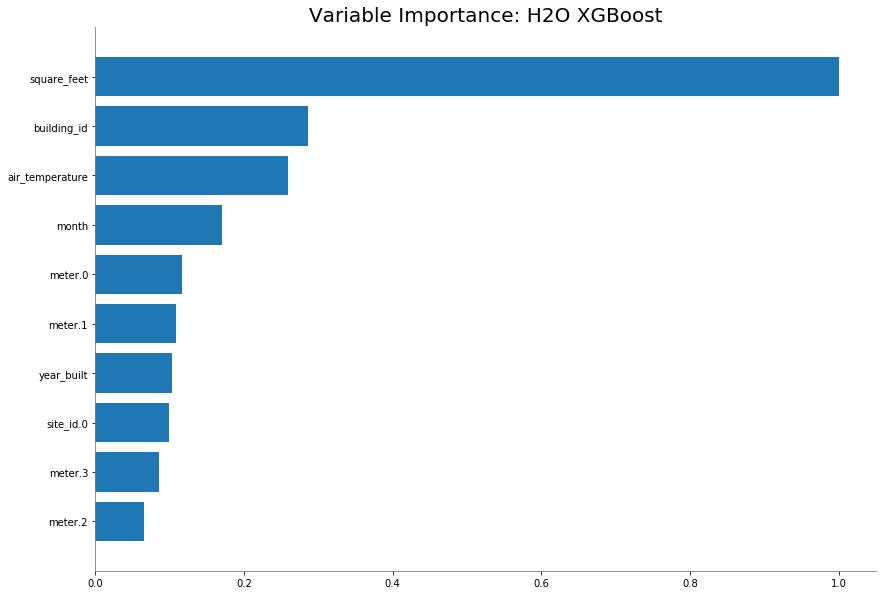

In [32]:
variables = model._model_json['output']['variable_importances']['variable']
scaled_importance = model._model_json['output']['variable_importances']['scaled_importance']

model.varimp_plot()

In [24]:
variables[0:15]

['square_feet',
 'building_id',
 'air_temperature',
 'month',
 'meter.0',
 'meter.1',
 'year_built',
 'site_id.0',
 'meter.3',
 'meter.2',
 'site_id.14',
 'dew_temperature',
 'primary_use.Education',
 'floor_count',
 'site_id.5']

# Performance

In [25]:
tic = time.time()
test_perf = model.model_performance(test)
toc = time.time()
print(toc-tic," seconds")

17.59766697883606  seconds


In [26]:
test_perf


ModelMetricsRegression: xgboost
** Reported on test data. **

MSE: 1.5596828644768785
RMSE: 1.2488726374121897
MAE: 0.9148178653664474
RMSLE: 0.3977648751753785
Mean Residual Deviance: 1.5596828644768785


# Prediction

In [27]:
tic = time.time()
predictions = model.predict(test_data = test)
toc = time.time()
print(toc-tic," seconds")

xgboost prediction progress: |████████████████████████████████████████████| 100%
20.26500630378723  seconds


In [28]:
predictions['predict'] = predictions['predict'].expm1()

In [29]:
predictions.tail()

predict
307.138
24.9603
12.5483
105.514
193.013
301.576
542.858
118.437
9.55491
52.2112


In [30]:
notebook_toc = time.time()

In [31]:
print("notebook completed in ",notebook_toc - notebook_tic," seconds")

notebook completed in  10743.415010929108  seconds
